In [1]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import poisson, expon, gamma
from scipy.special import factorial
from sklearn.linear_model import LinearRegression, PoissonRegressor
from statsmodels.tsa.ar_model import AutoReg

from get_model_training_data_05 import get_features_and_data
from get_model_training_data_05 import weighted_absolute_percentage_error as wape

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

# warnings.filterwarnings("ignore")
# os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
(df, train_df, test_df, feature_names, next_month) = get_features_and_data()

/Users/diane/Library/CloudStorage/Dropbox/troon_release_prediction/get_model_training_data_05.py:52: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["release_preorder"] = df["release_preorder"].fillna(False)


training examples = 2500, testing examples = 327


/Users/diane/Library/CloudStorage/Dropbox/troon_release_prediction/get_model_training_data_05.py:116: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["previous_release_preorder"] = df["release_preorder"].shift().fillna(False).astype(int)


In [4]:
df.columns

Index(['index', 'days_since_previous_release', 'release', 'release_preorder',
       'days_until_next_release', 'prob_of_release', 'days_until_next_holiday',
       'weekday', 'year', 'WD_Monday', 'WD_Saturday', 'WD_Sunday',
       'WD_Thursday', 'WD_Tuesday', 'WD_Wednesday', 'previous_release',
       'previous_release_preorder'],
      dtype='object')

In [5]:
df[df["release"] == 1]["days_since_previous_release"].mean()

6.955773955773956

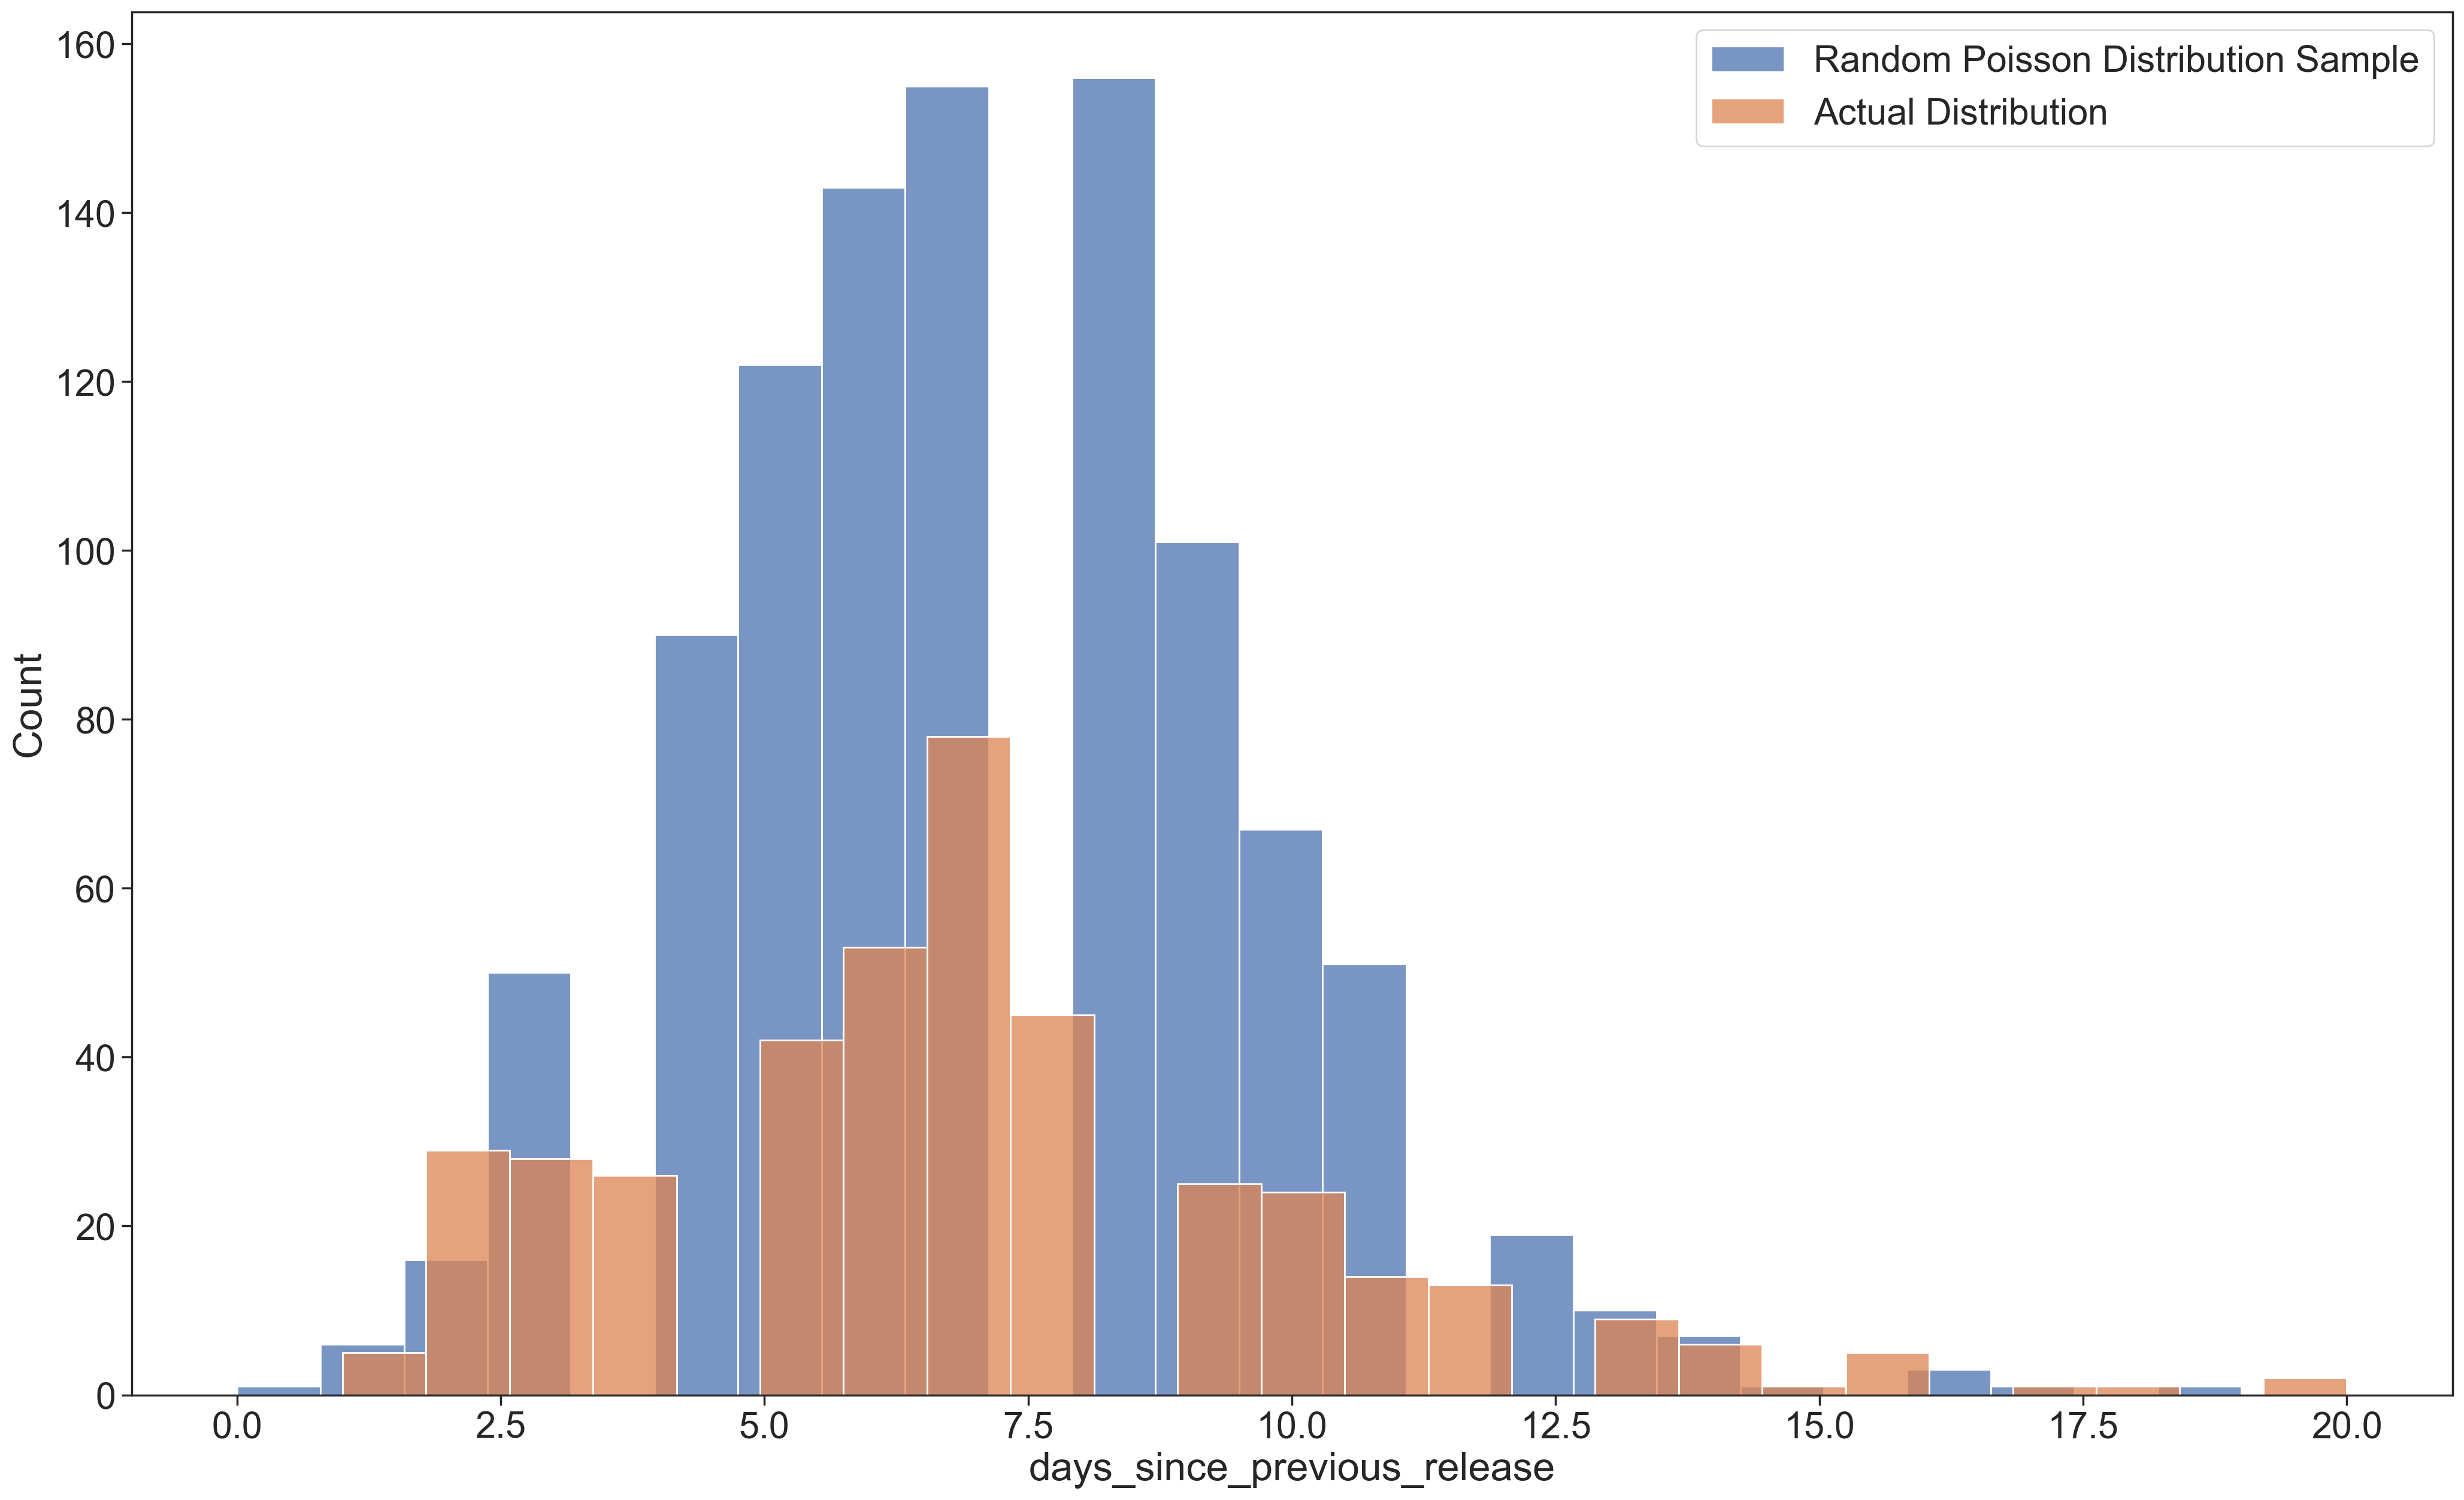

In [6]:
ax = sns.histplot(poisson.rvs(7, size=1000), label="Random Poisson Distribution Sample")
sns.histplot(x=df[df["release"] == 1]["days_since_previous_release"], ax=ax, label="Actual Distribution")
ax.legend()
plt.show()

In [7]:
df[df["release"] == 1]["days_until_next_release"].mean()

6.943488943488943

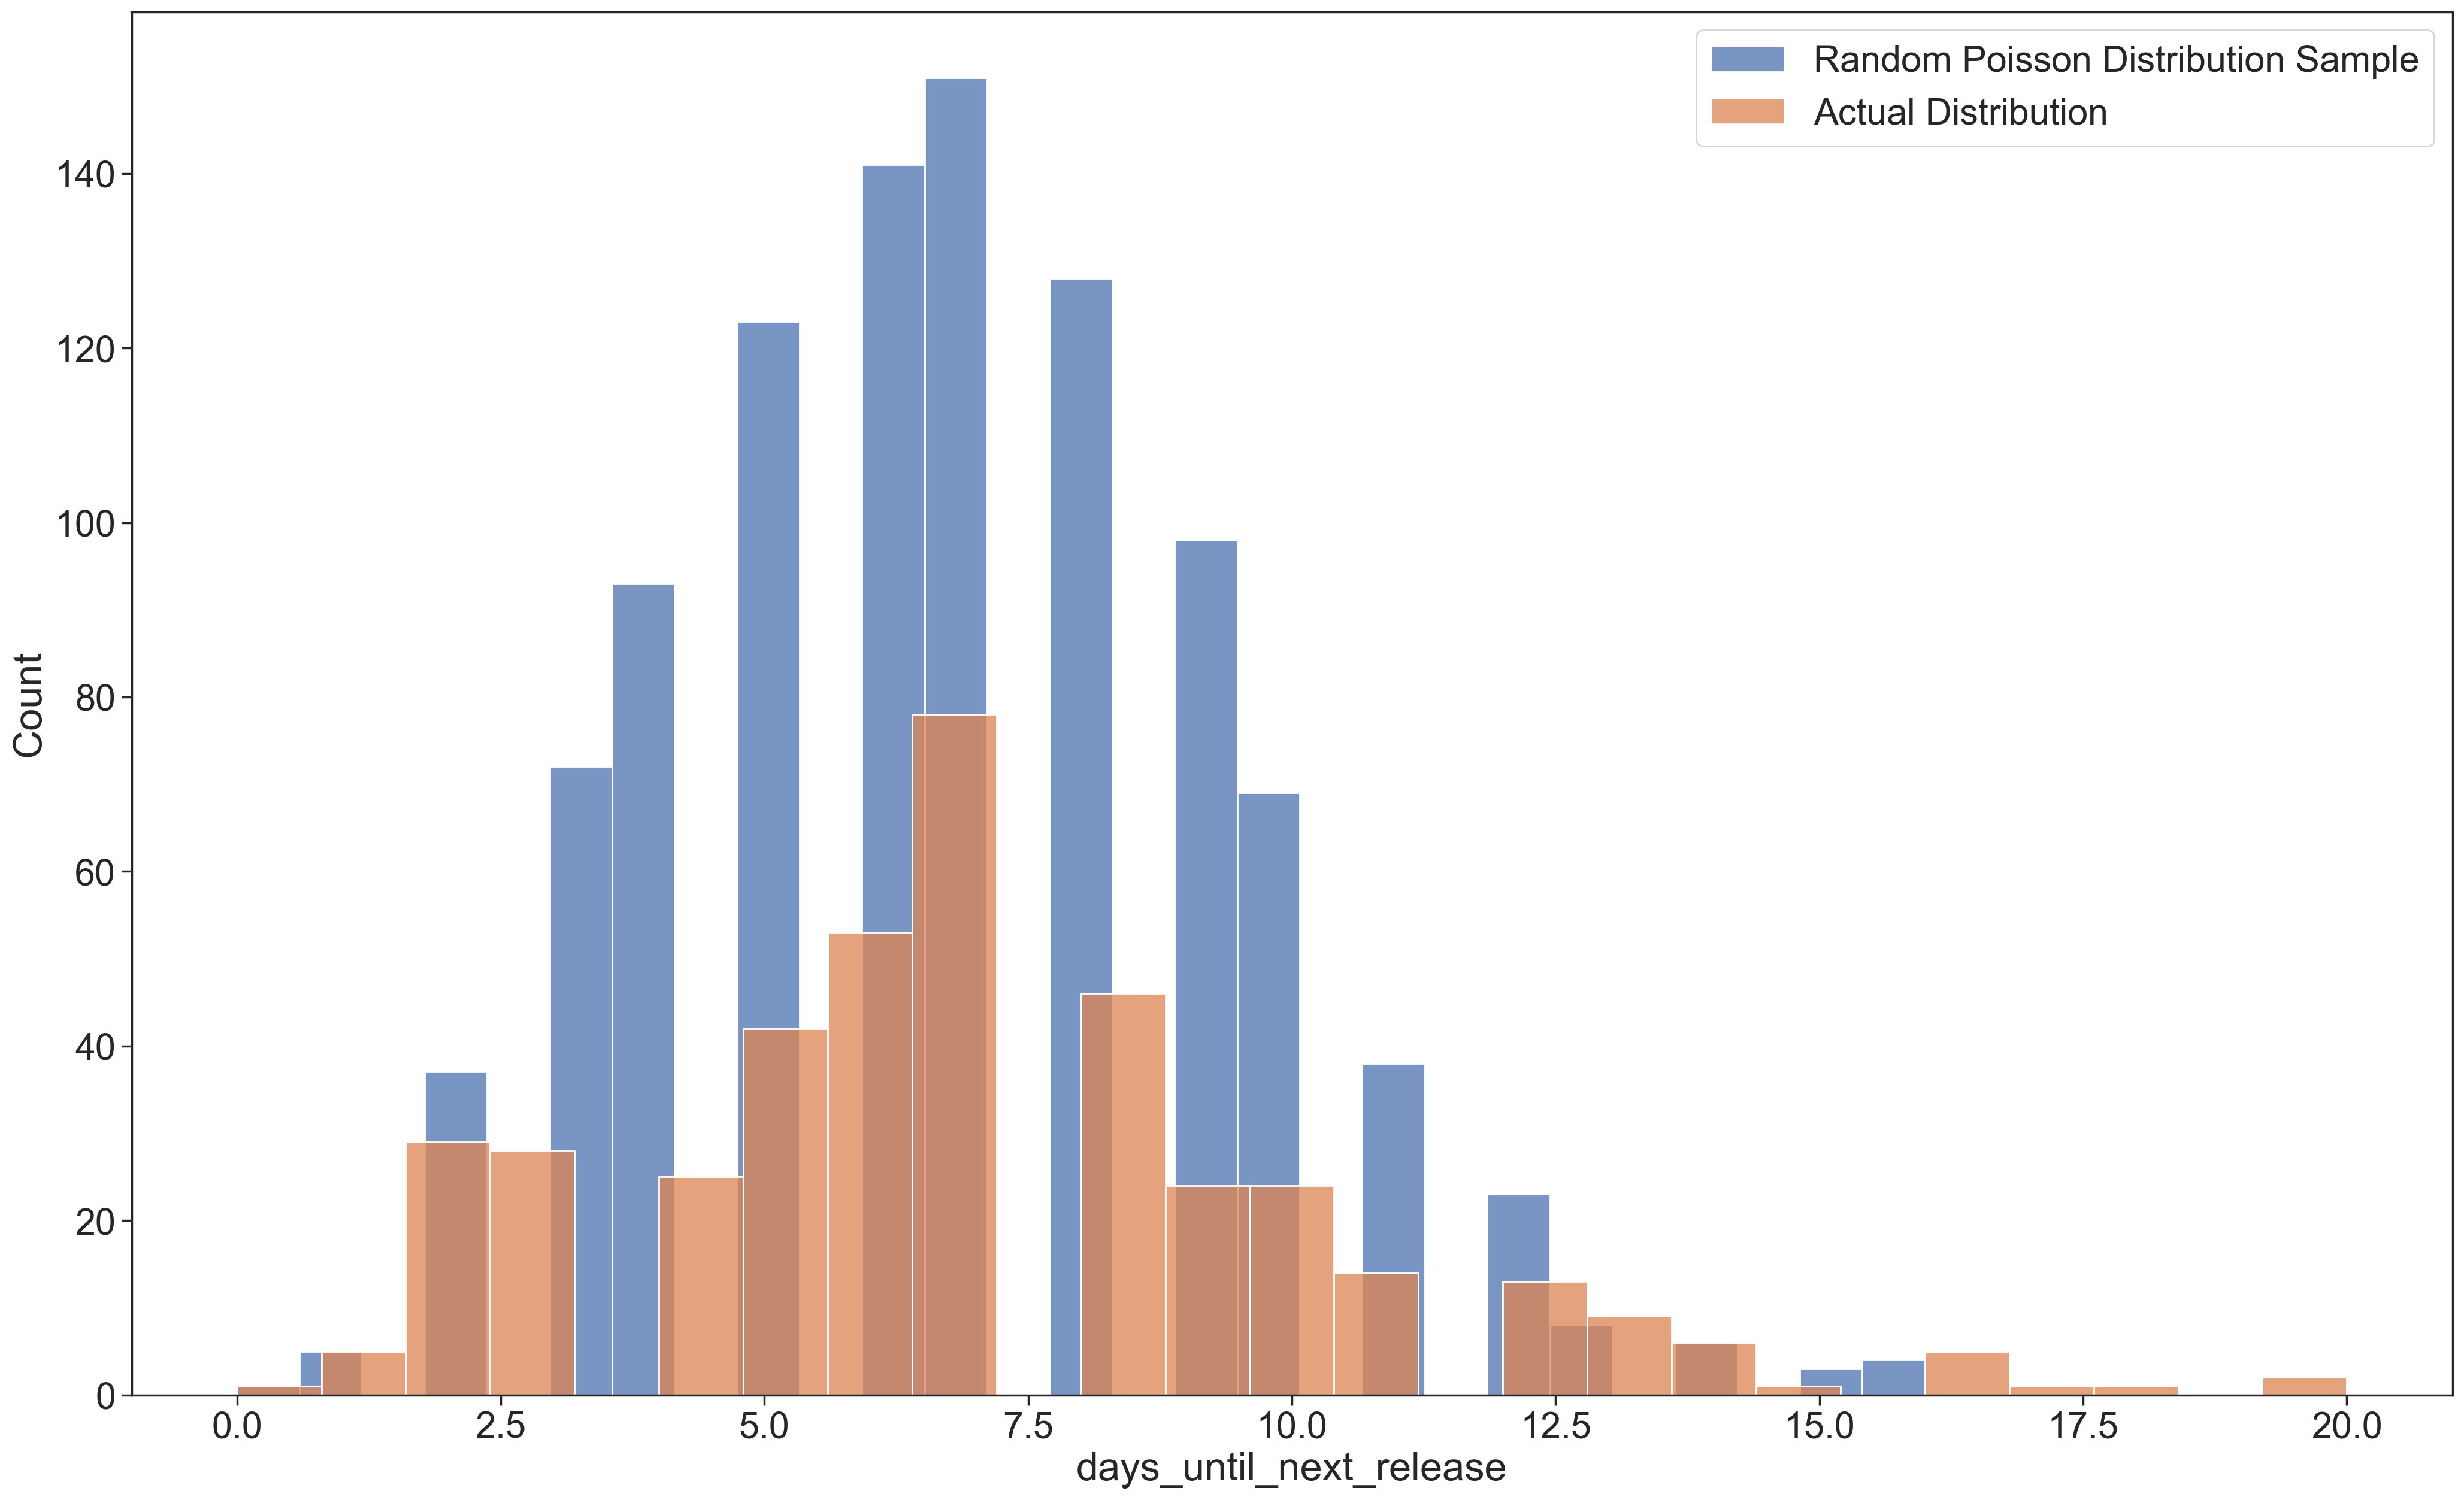

In [8]:
ax = sns.histplot(poisson.rvs(6.955665024630542, size=1000), label="Random Poisson Distribution Sample")
sns.histplot(x=df[df["release"] == 1]["days_until_next_release"], ax=ax, label="Actual Distribution")
ax.legend()
plt.show()

<Axes: xlabel='month_holidays', ylabel='Count'>

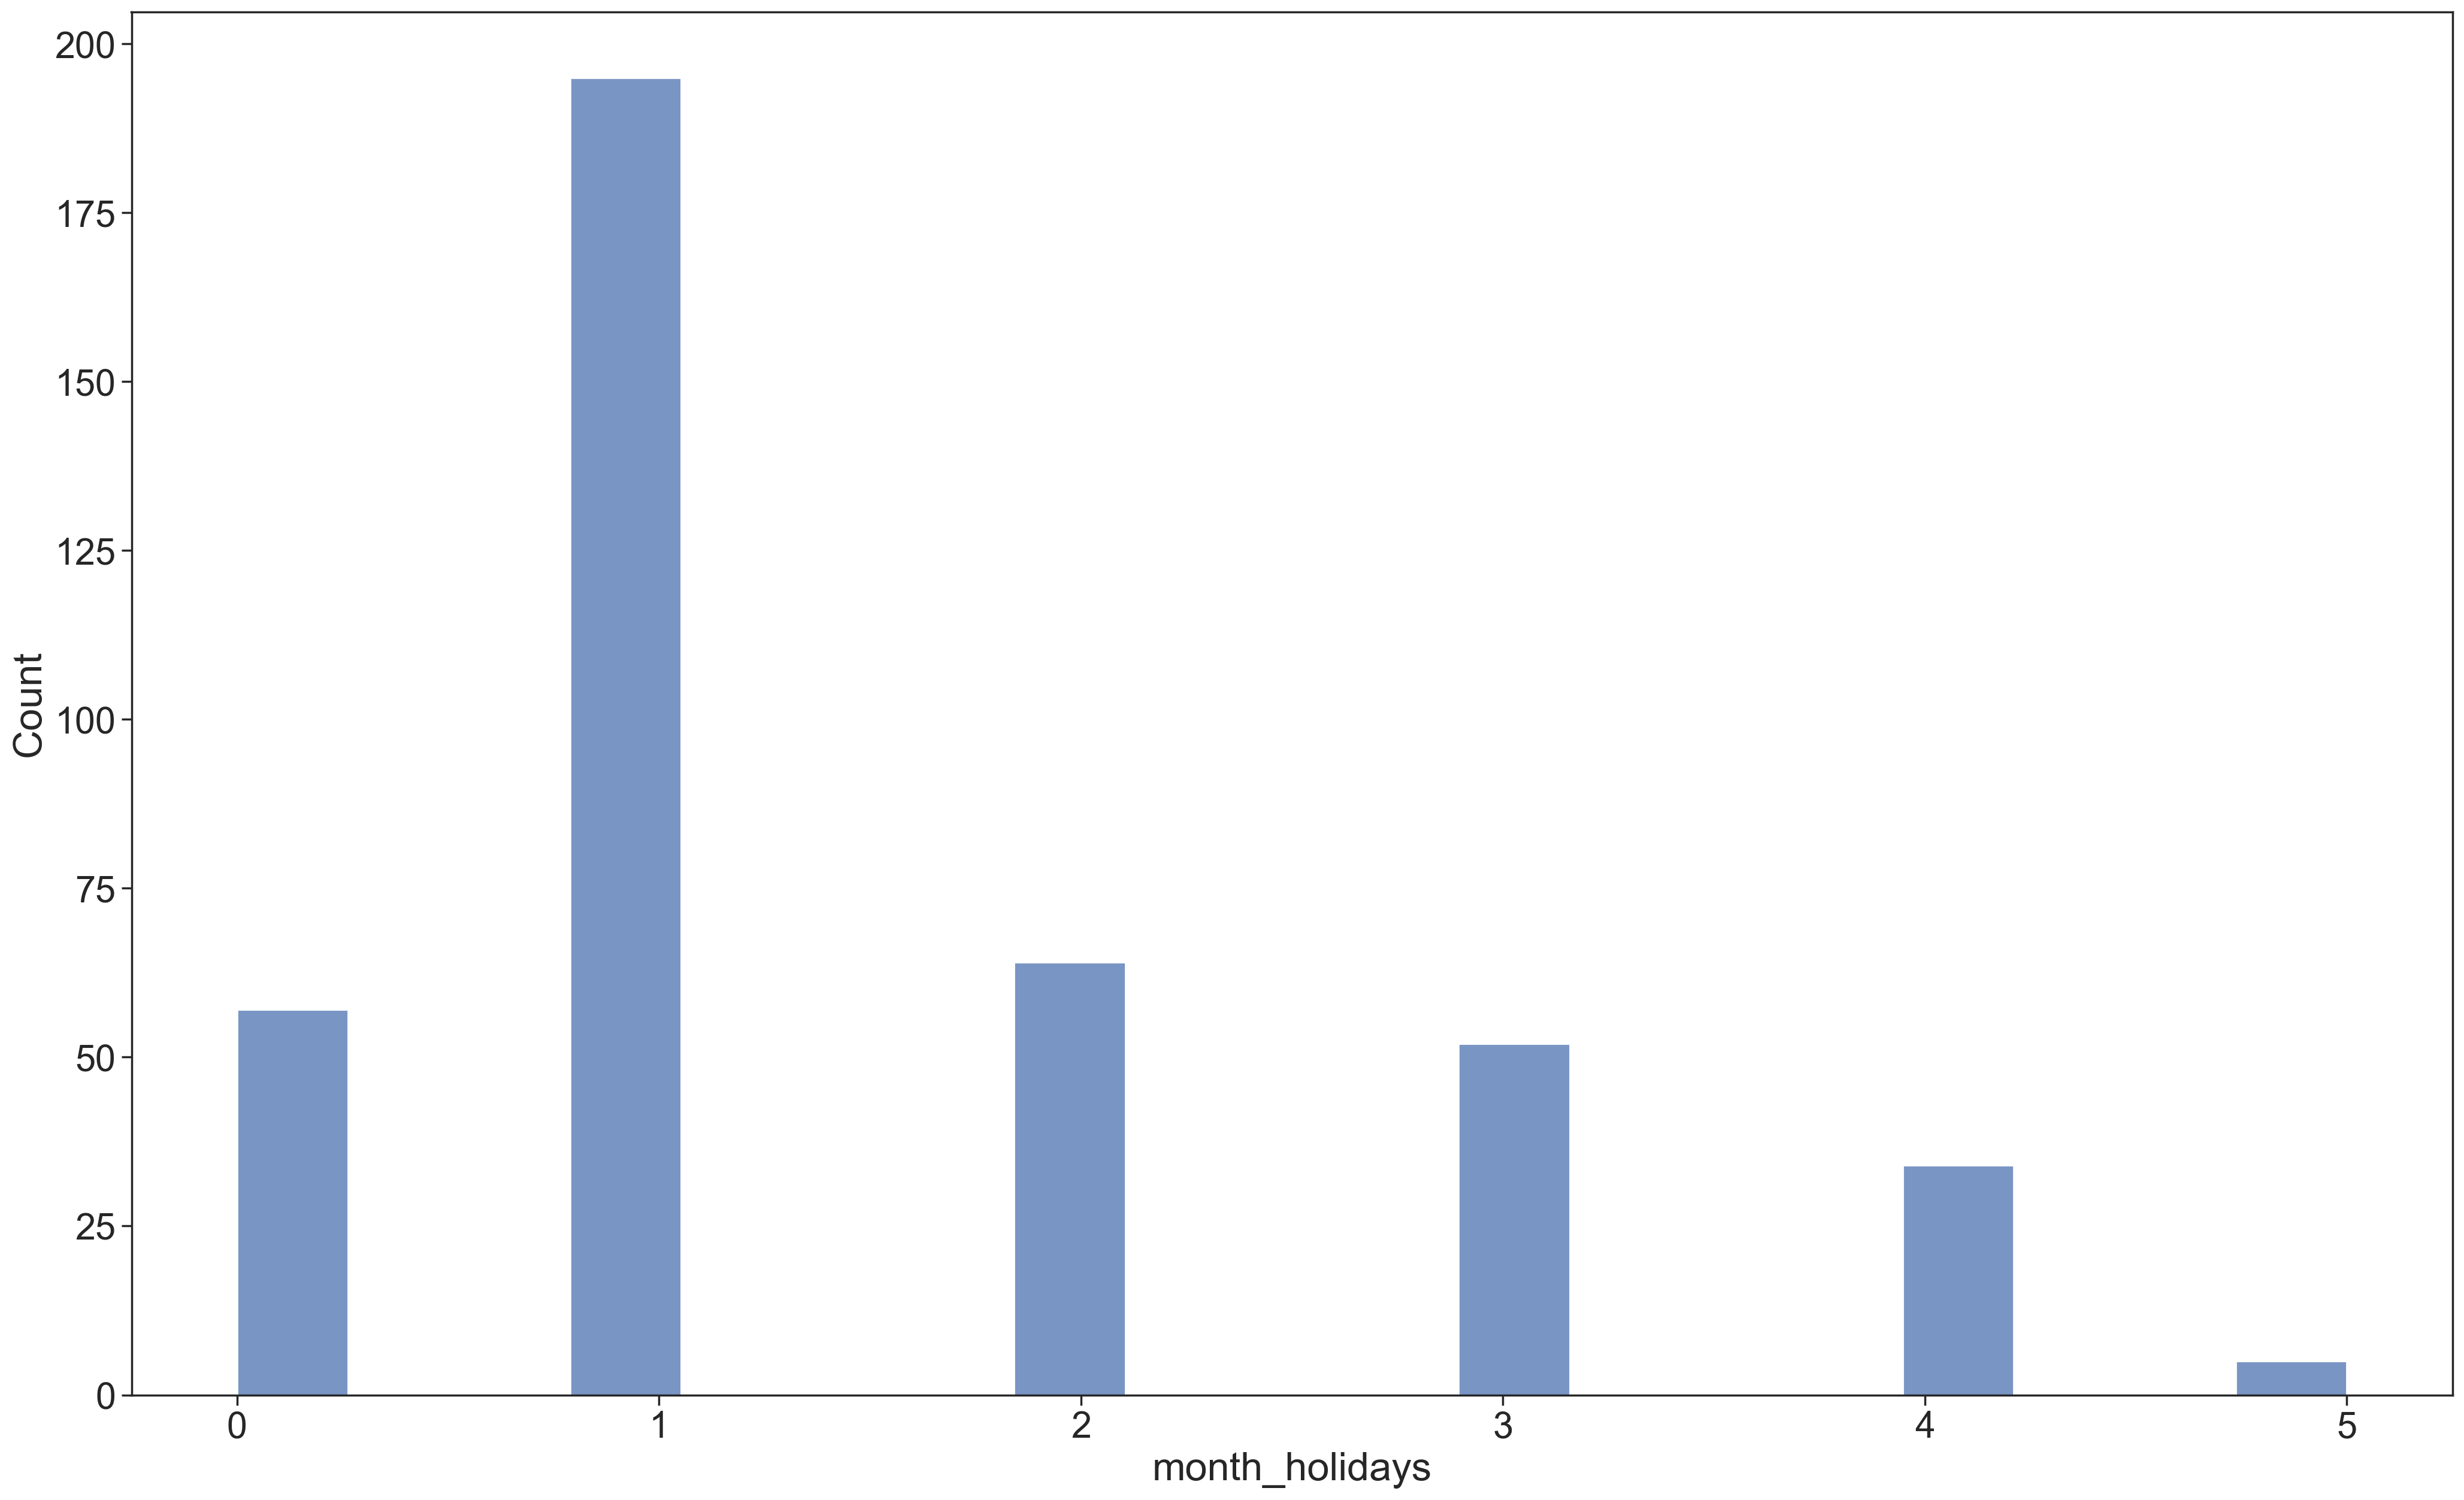

In [9]:
sns.histplot(x=df[df["release"] == 1]["month_holidays"])

<Axes: xlabel='days_until_next_holiday', ylabel='Count'>

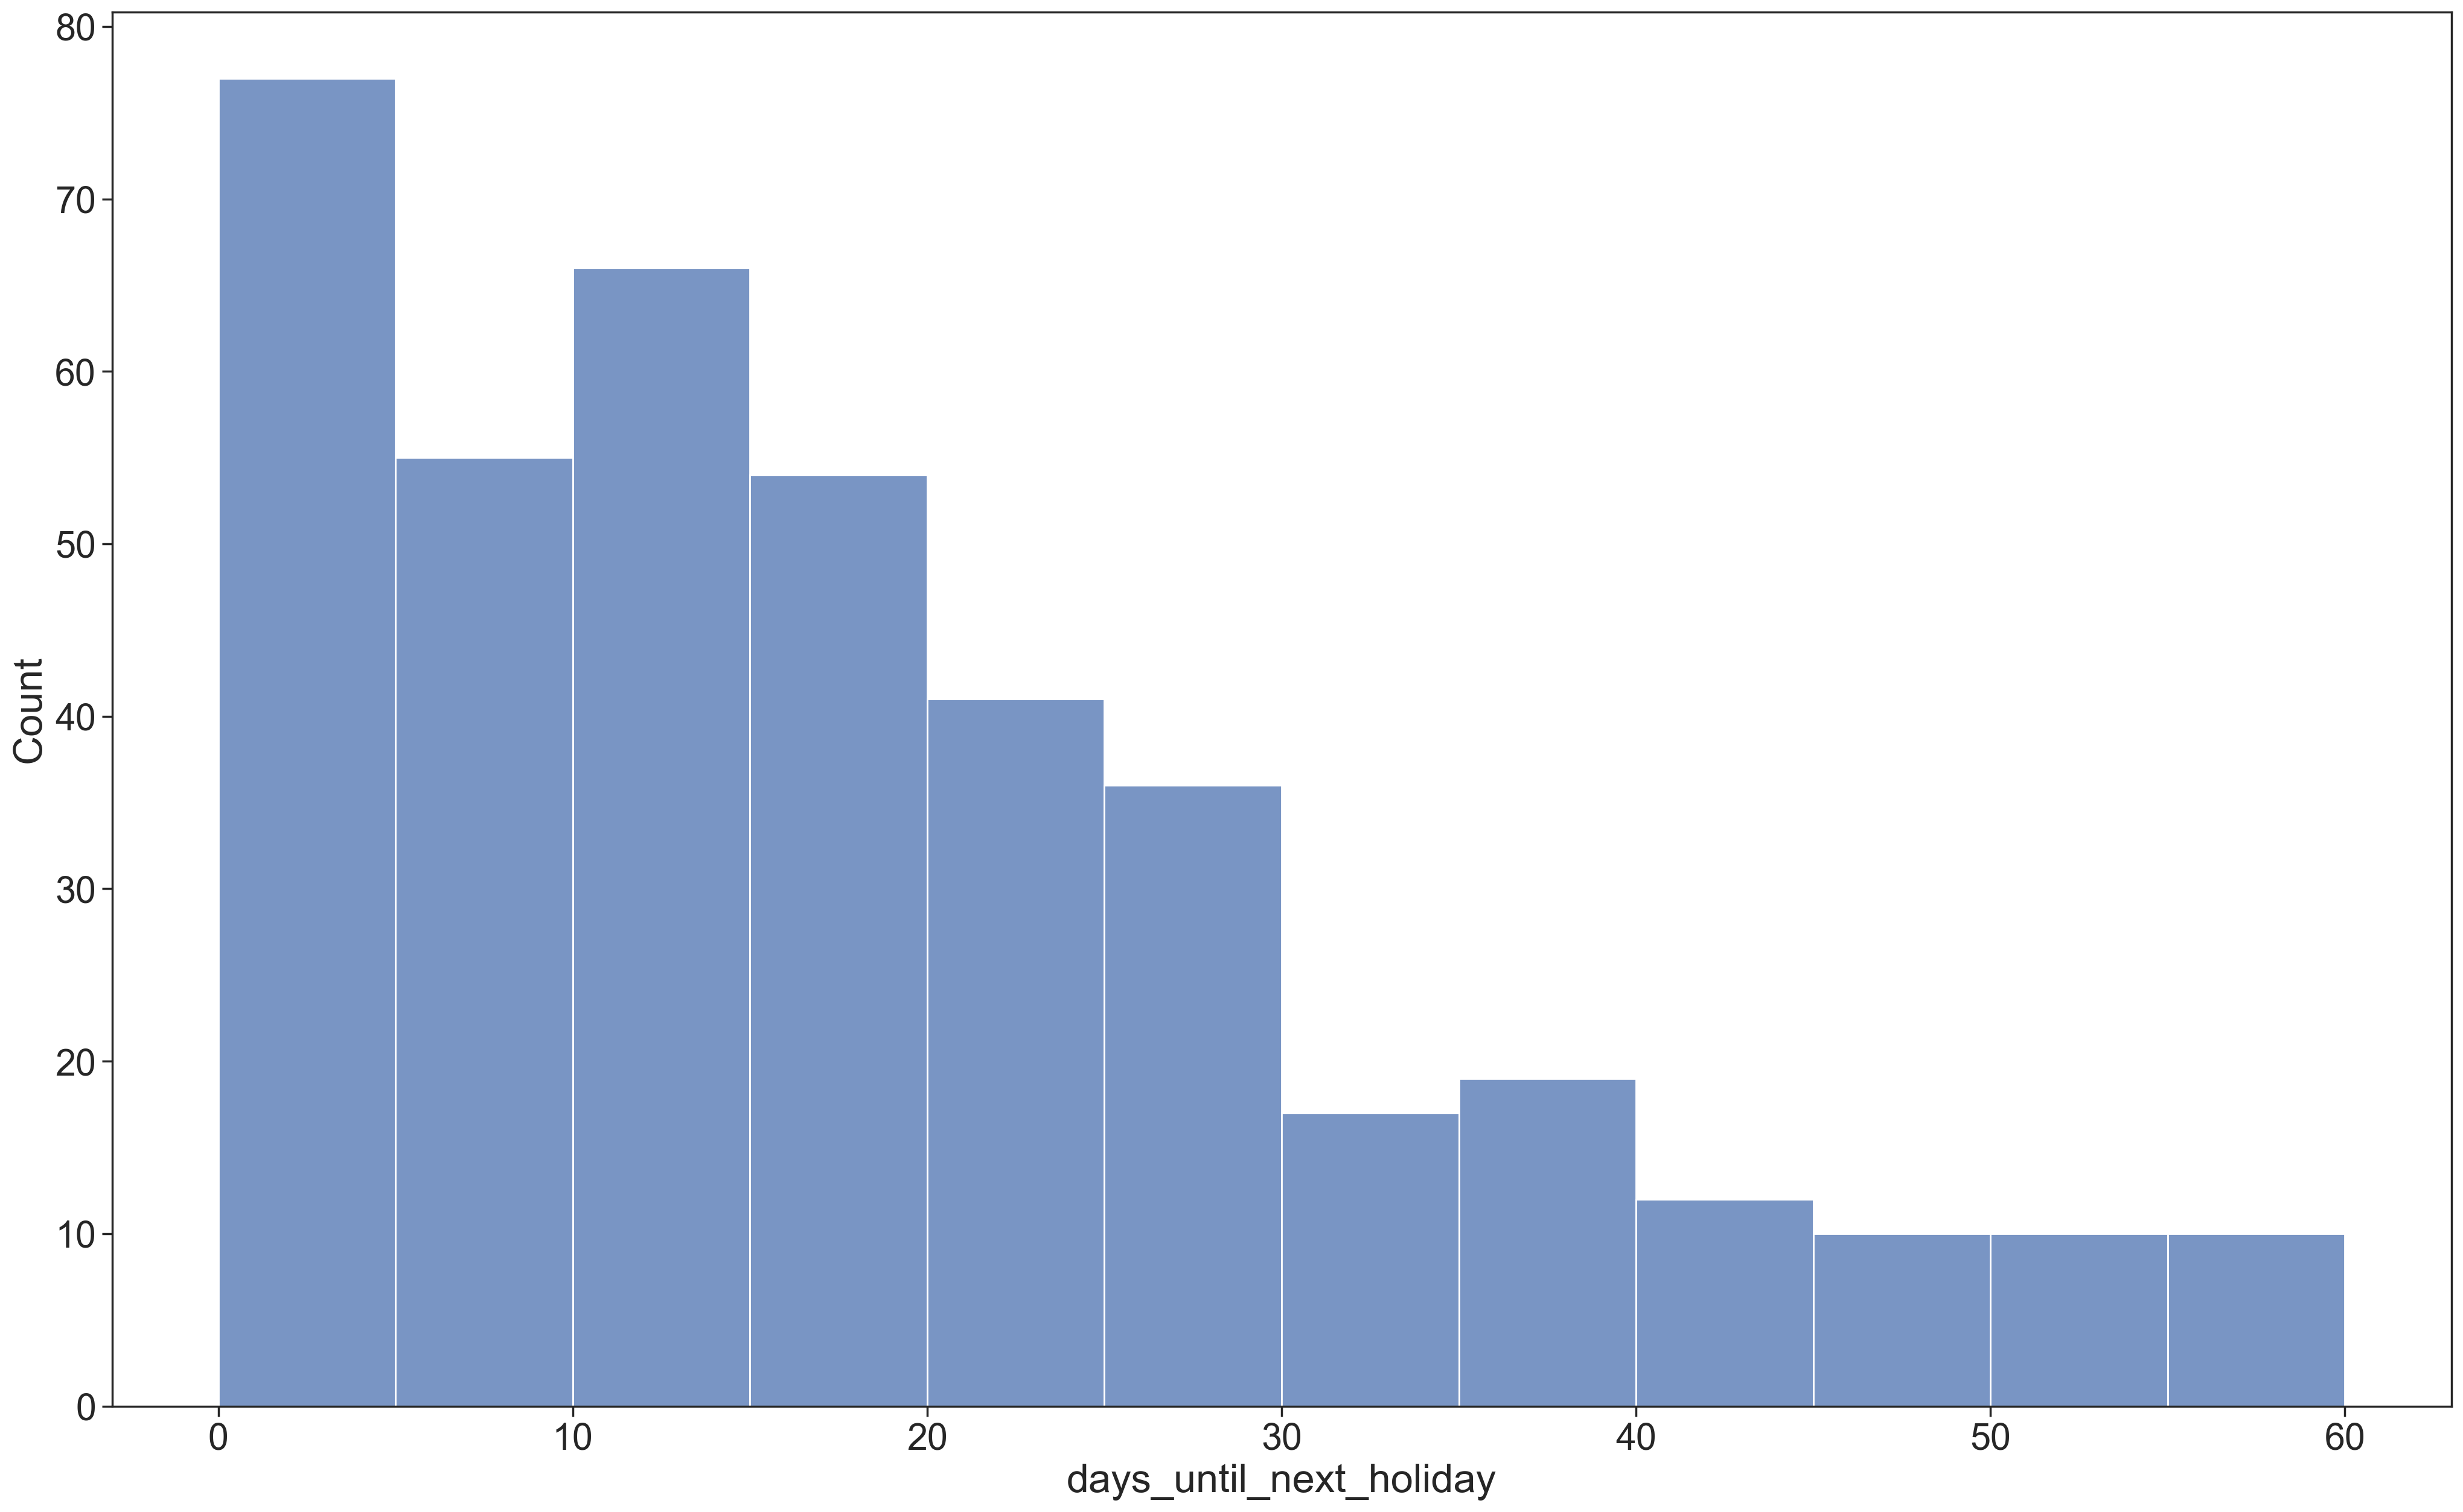

In [10]:
sns.histplot(x=df[df["release"] == 1]["days_until_next_holiday"])

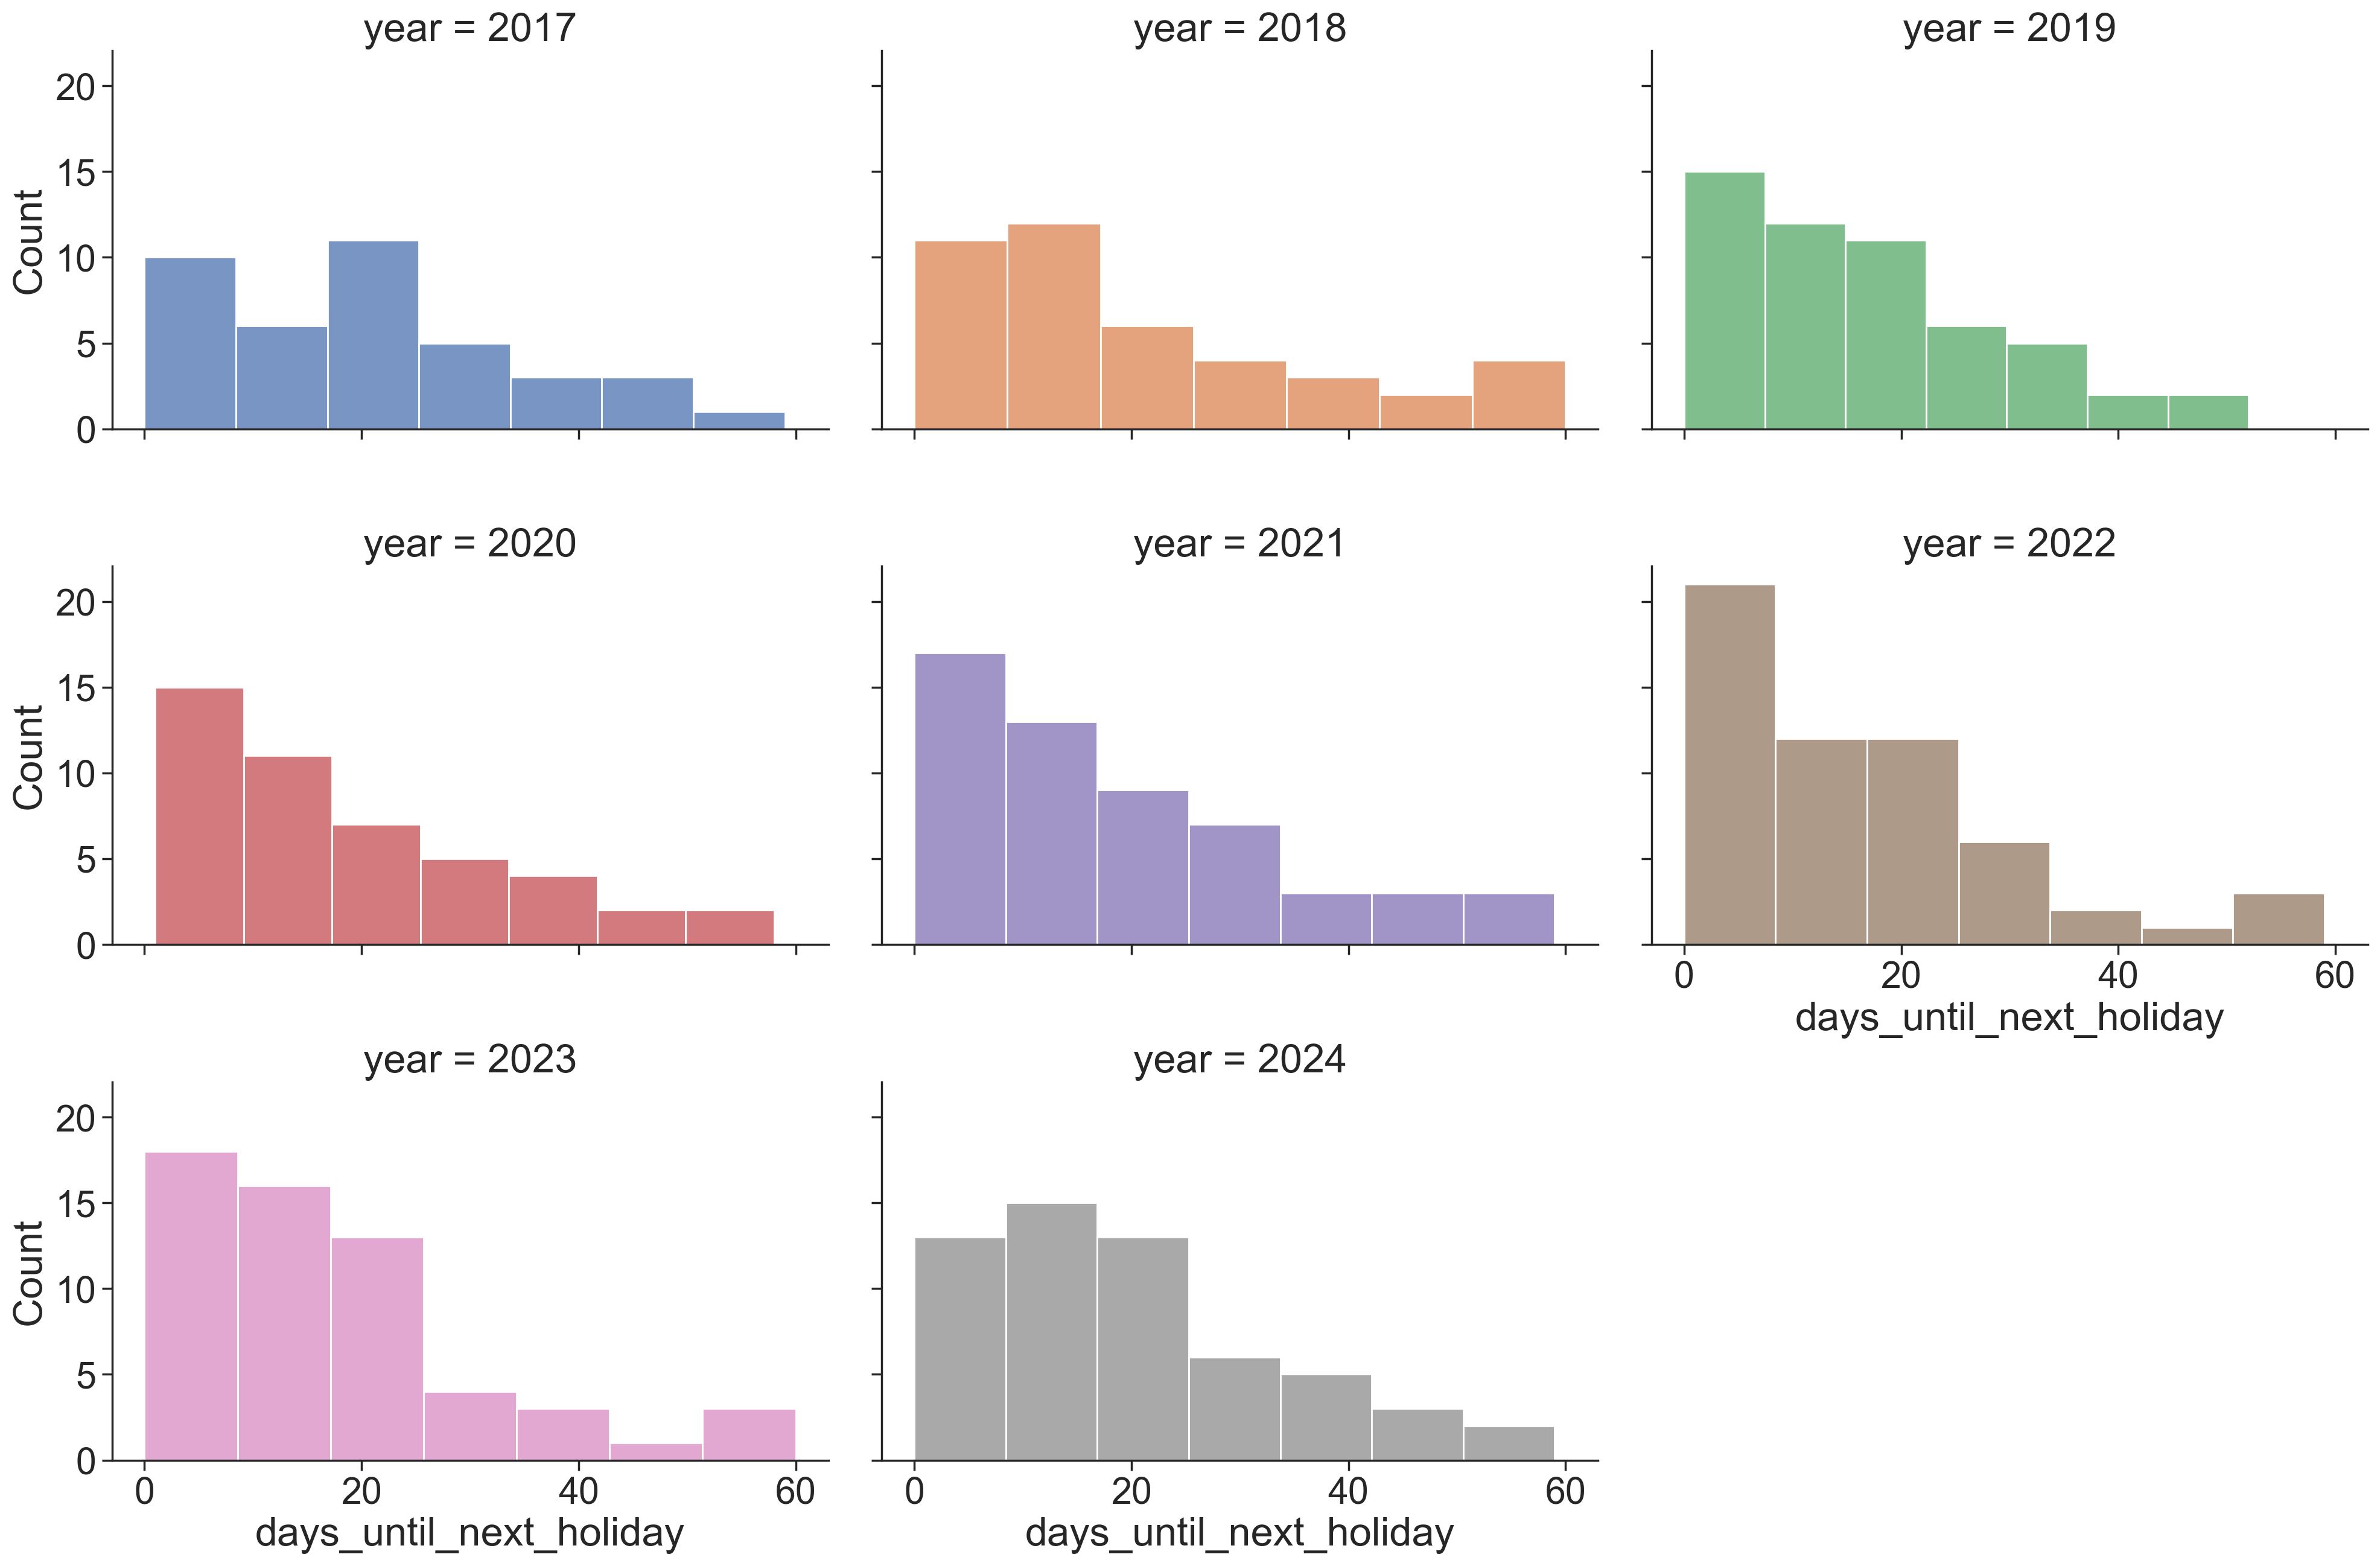

In [12]:
g = sns.FacetGrid(df[df["release"] == 1], col="year", col_wrap=3, aspect=1.5, height=4.5, hue="year")
g.map(sns.histplot, "days_until_next_holiday")
# g.set_xlabels("")
plt.tight_layout()

---

In [14]:
release_df = df[df["release"] == 1].copy()

In [17]:
release_df[release_df["year"] >= 2019].corr(numeric_only=True).dropna(how="all").dropna(how="all", axis=1)

,days_since_previous_release,release_preorder,days_until_next_release,prob_of_release,days_until_next_holiday,year,WD_Monday,WD_Saturday,WD_Sunday,WD_Thursday,WD_Tuesday,WD_Wednesday,previous_release
days_since_previous_release,1.000000,-0.002068,-0.215156,0.724490,-0.056178,-0.169064,0.032266,-0.033381,-0.046105,-0.045930,0.143962,0.039687,-0.145247
release_preorder,-0.002068,1.000000,0.025522,-0.036677,0.018582,0.217663,0.043415,-0.029662,0.003251,-0.002080,-0.108386,-0.017490,-0.059965
days_until_next_release,-0.215156,0.025522,1.000000,-0.750501,0.001487,-0.168060,-0.048913,0.022553,0.157594,0.066922,-0.074578,-0.105967,0.077679
prob_of_release,0.724490,-0.036677,-0.750501,1.000000,-0.024748,0.015022,0.051399,-0.058850,-0.129734,-0.069971,0.155130,0.141269,-0.180372
days_until_next_holiday,-0.056178,0.018582,0.001487,-0.024748,1.000000,0.030136,0.051979,-0.037427,0.035393,-0.084277,0.045616,-0.025665,-0.067287
year,-0.169064,0.217663,-0.168060,0.015022,0.030136,1.000000,-0.028345,-0.118774,-0.178483,0.005163,-0.010816,-0.007919,-0.073250
WD_Monday,0.032266,0.043415,-0.048913,0.051399,0.051979,-0.028345,1.000000,-0.078366,-0.058081,-0.134900,-0.103623,-0.134900,-0.020086
WD_Saturday,-0.033381,-0.029662,0.022553,-0.058850,-0.037427,-0.118774,-0.078366,1.000000,-0.069639,-0.161745,-0.124243,-0.161745,-0.024083
WD_Sunday,-0.046105,0.003251,0.157594,-0.129734,0.035393,-0.178483,-0.058081,-0.069639,1.000000,-0.119878,-0.092083,-0.119878,-0.017849
WD_Thursday,-0.045930,-0.002080,0.066922,-0.069971,-0.084277,0.005163,-0.134900,-0.161745,-0.119878,1.000000,-0.213874,-0.278431,0.148896


In [132]:
lr = LinearRegression()
lr.fit(release_df[["days_since_previous_release"]], release_df["days_until_next_release"])

LinearRegression()

In [133]:
lr.score(release_df[["days_since_previous_release"]], release_df["days_until_next_release"])

0.027050721685498602

In [134]:
lr.coef_

array([-0.16516366])

In [135]:
lr.intercept_

8.106522127887867

In [136]:
release_df[["days_since_previous_release", "days_until_next_release"]].mean()

days_since_previous_release    6.967980
days_until_next_release        6.955665
dtype: float64

In [137]:
release_df[["days_since_previous_release", "days_until_next_release"]].std()

days_since_previous_release    3.273004
days_until_next_release        3.286787
dtype: float64

In [138]:
pr = PoissonRegressor()
pr.fit(release_df[["days_since_previous_release"]], release_df["days_until_next_release"])

PoissonRegressor()

In [139]:
pr.score(release_df[["days_since_previous_release"]], release_df["days_until_next_release"])

0.02745731286074915

In [140]:
pr.coef_

array([-0.02414678])

In [141]:
pr.intercept_

2.1047587859694152

In [142]:
release_df["pred"] = pr.predict(release_df[["days_since_previous_release"]])

In [143]:
release_df[["days_until_next_release", "pred"]]

,days_until_next_release,pred
0,20.0,6.602430
20,6.0,5.062311
26,6.0,7.098462
32,9.0,7.098462
41,8.0,6.602430
...,...,...
2798,6.0,6.929110
2804,6.0,7.098462
2810,6.0,7.098462
2816,8.0,7.098462


In [13]:
lr = LinearRegression().fit(release_df[["days_until_next_holiday"]], release_df["days_until_next_release"])

In [14]:
lr.score(release_df[["days_until_next_holiday"]], release_df["days_until_next_release"])

0.0006130824233745447

In [15]:
lr.intercept_

7.045214176871963

In [16]:
lr.coef_

array([-0.00558432])

---

In [145]:
df = df.set_index("index")

In [146]:
df.resample("W")["release"].sum().value_counts()

release
1    263
0     71
2     70
3      1
Name: count, dtype: Int64

In [147]:
df.resample("W")["release"].sum().value_counts() / df["release"].sum()

release
1    0.647783
0    0.174877
2    0.172414
3    0.002463
Name: count, dtype: Float64

In [148]:
np.log(0.187845)

-1.6721381242980315

In [149]:
# probability mass function

k = list(range(0, 10)) # number of release per week
p = [] # prob under Poisson distribution
mu = 1.6721381242980315

for i in k:
    p.append(np.exp(mu * -1) * ((mu ** i) / factorial(i)))

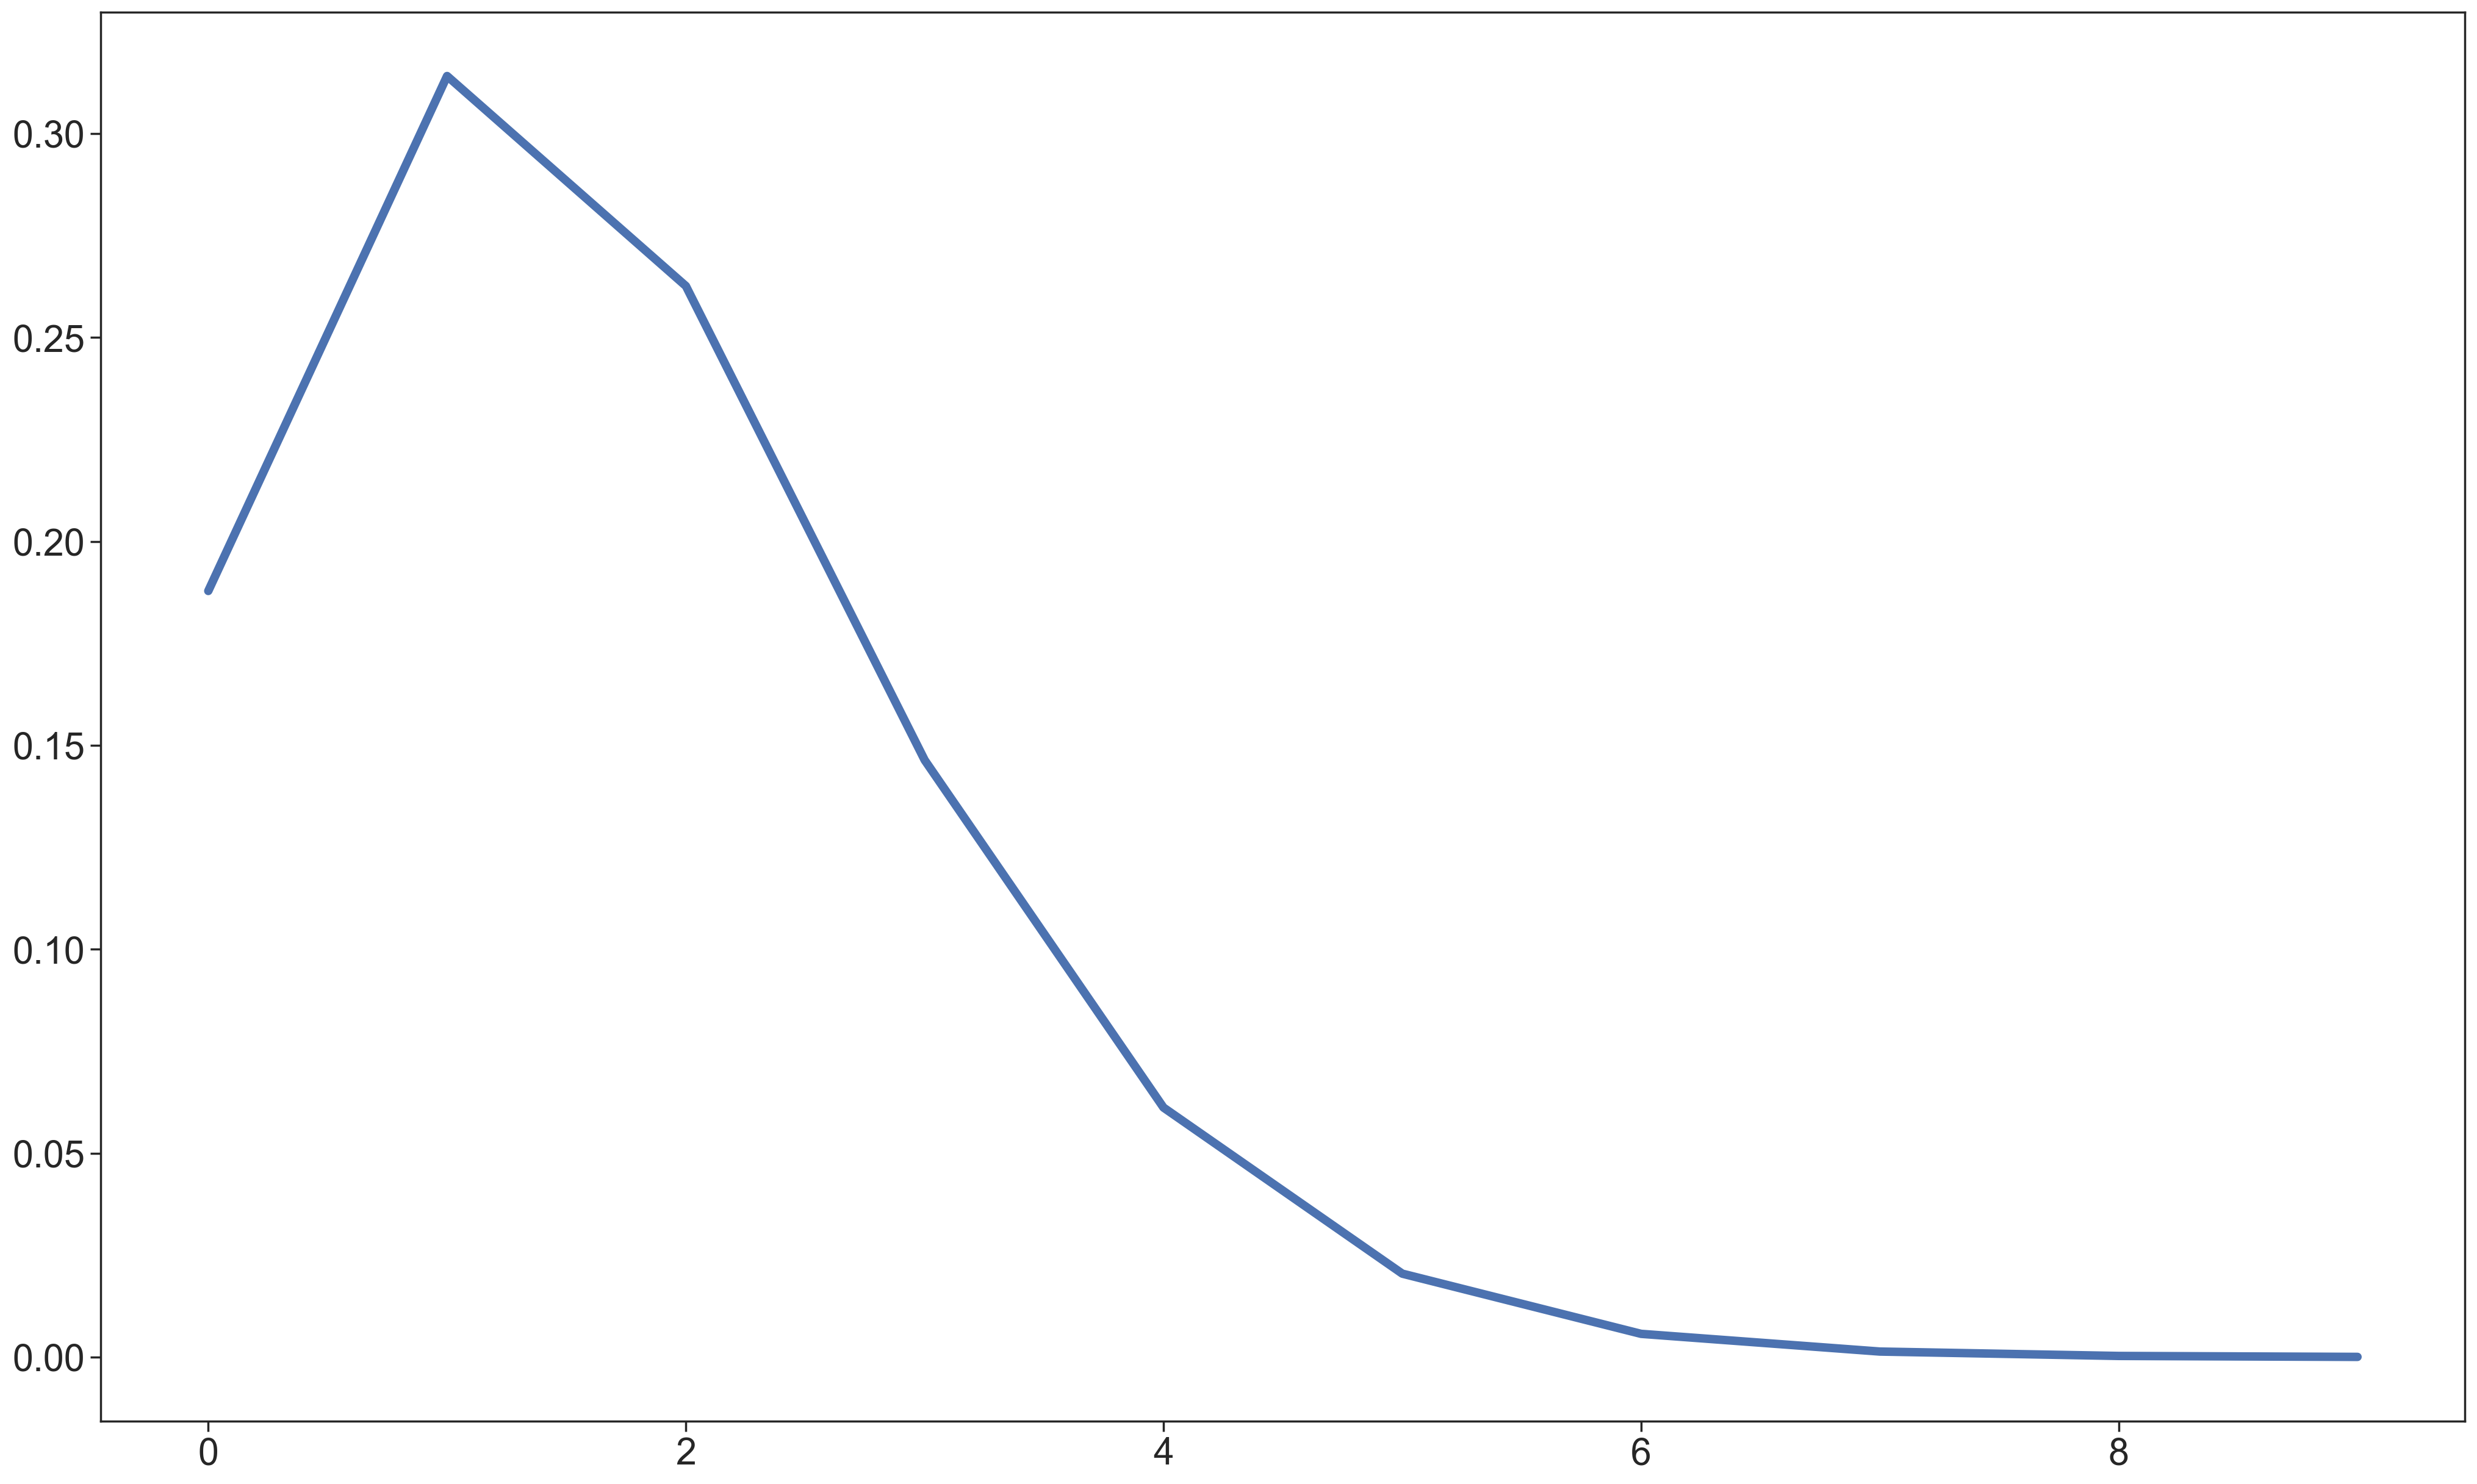

In [150]:
ax = sns.lineplot(x=k, y=p, linewidth=5)
plt.show()

In [151]:
poisson.pmf(mu=mu, k=1)

0.3141027859587638

In [152]:
p

[0.187845,
 0.31410278595876373,
 0.2626116216749366,
 0.14637430149546427,
 0.06118951248701505,
 0.020463463327349666,
 0.0057029561974726705,
 0.0013623043541422554,
 0.000284745130932309,
 5.290368768223873e-05]

In [153]:
poisson.rvs(mu=mu, loc=((0 + 1 + 2 + 3) / 4), size=100)

array([1, 1, 2, 3, 2, 4, 1, 2, 3, 3, 2, 5, 2, 4, 3, 3, 3, 3, 3, 2, 2, 2,
       2, 3, 3, 3, 1, 2, 1, 2, 4, 2, 3, 3, 1, 3, 1, 3, 2, 3, 2, 1, 2, 1,
       7, 2, 2, 4, 2, 3, 6, 1, 1, 1, 2, 2, 1, 3, 2, 2, 6, 2, 3, 1, 5, 1,
       5, 2, 4, 3, 1, 4, 3, 6, 3, 4, 2, 3, 2, 4, 4, 5, 7, 2, 2, 2, 5, 1,
       3, 2, 1, 6, 4, 2, 3, 2, 2, 2, 2, 4])

In [154]:
(0 + 1 + 2 + 3) / 4

1.5

---

In [155]:
temp = df[df["release"] == 1].copy().reset_index()
temp["index"].dt.year.value_counts() / 52

index
2023    1.115385
2022    1.096154
2024    1.076923
2021    1.057692
2019    1.019231
2020    0.884615
2018    0.807692
2017    0.750000
Name: count, dtype: float64

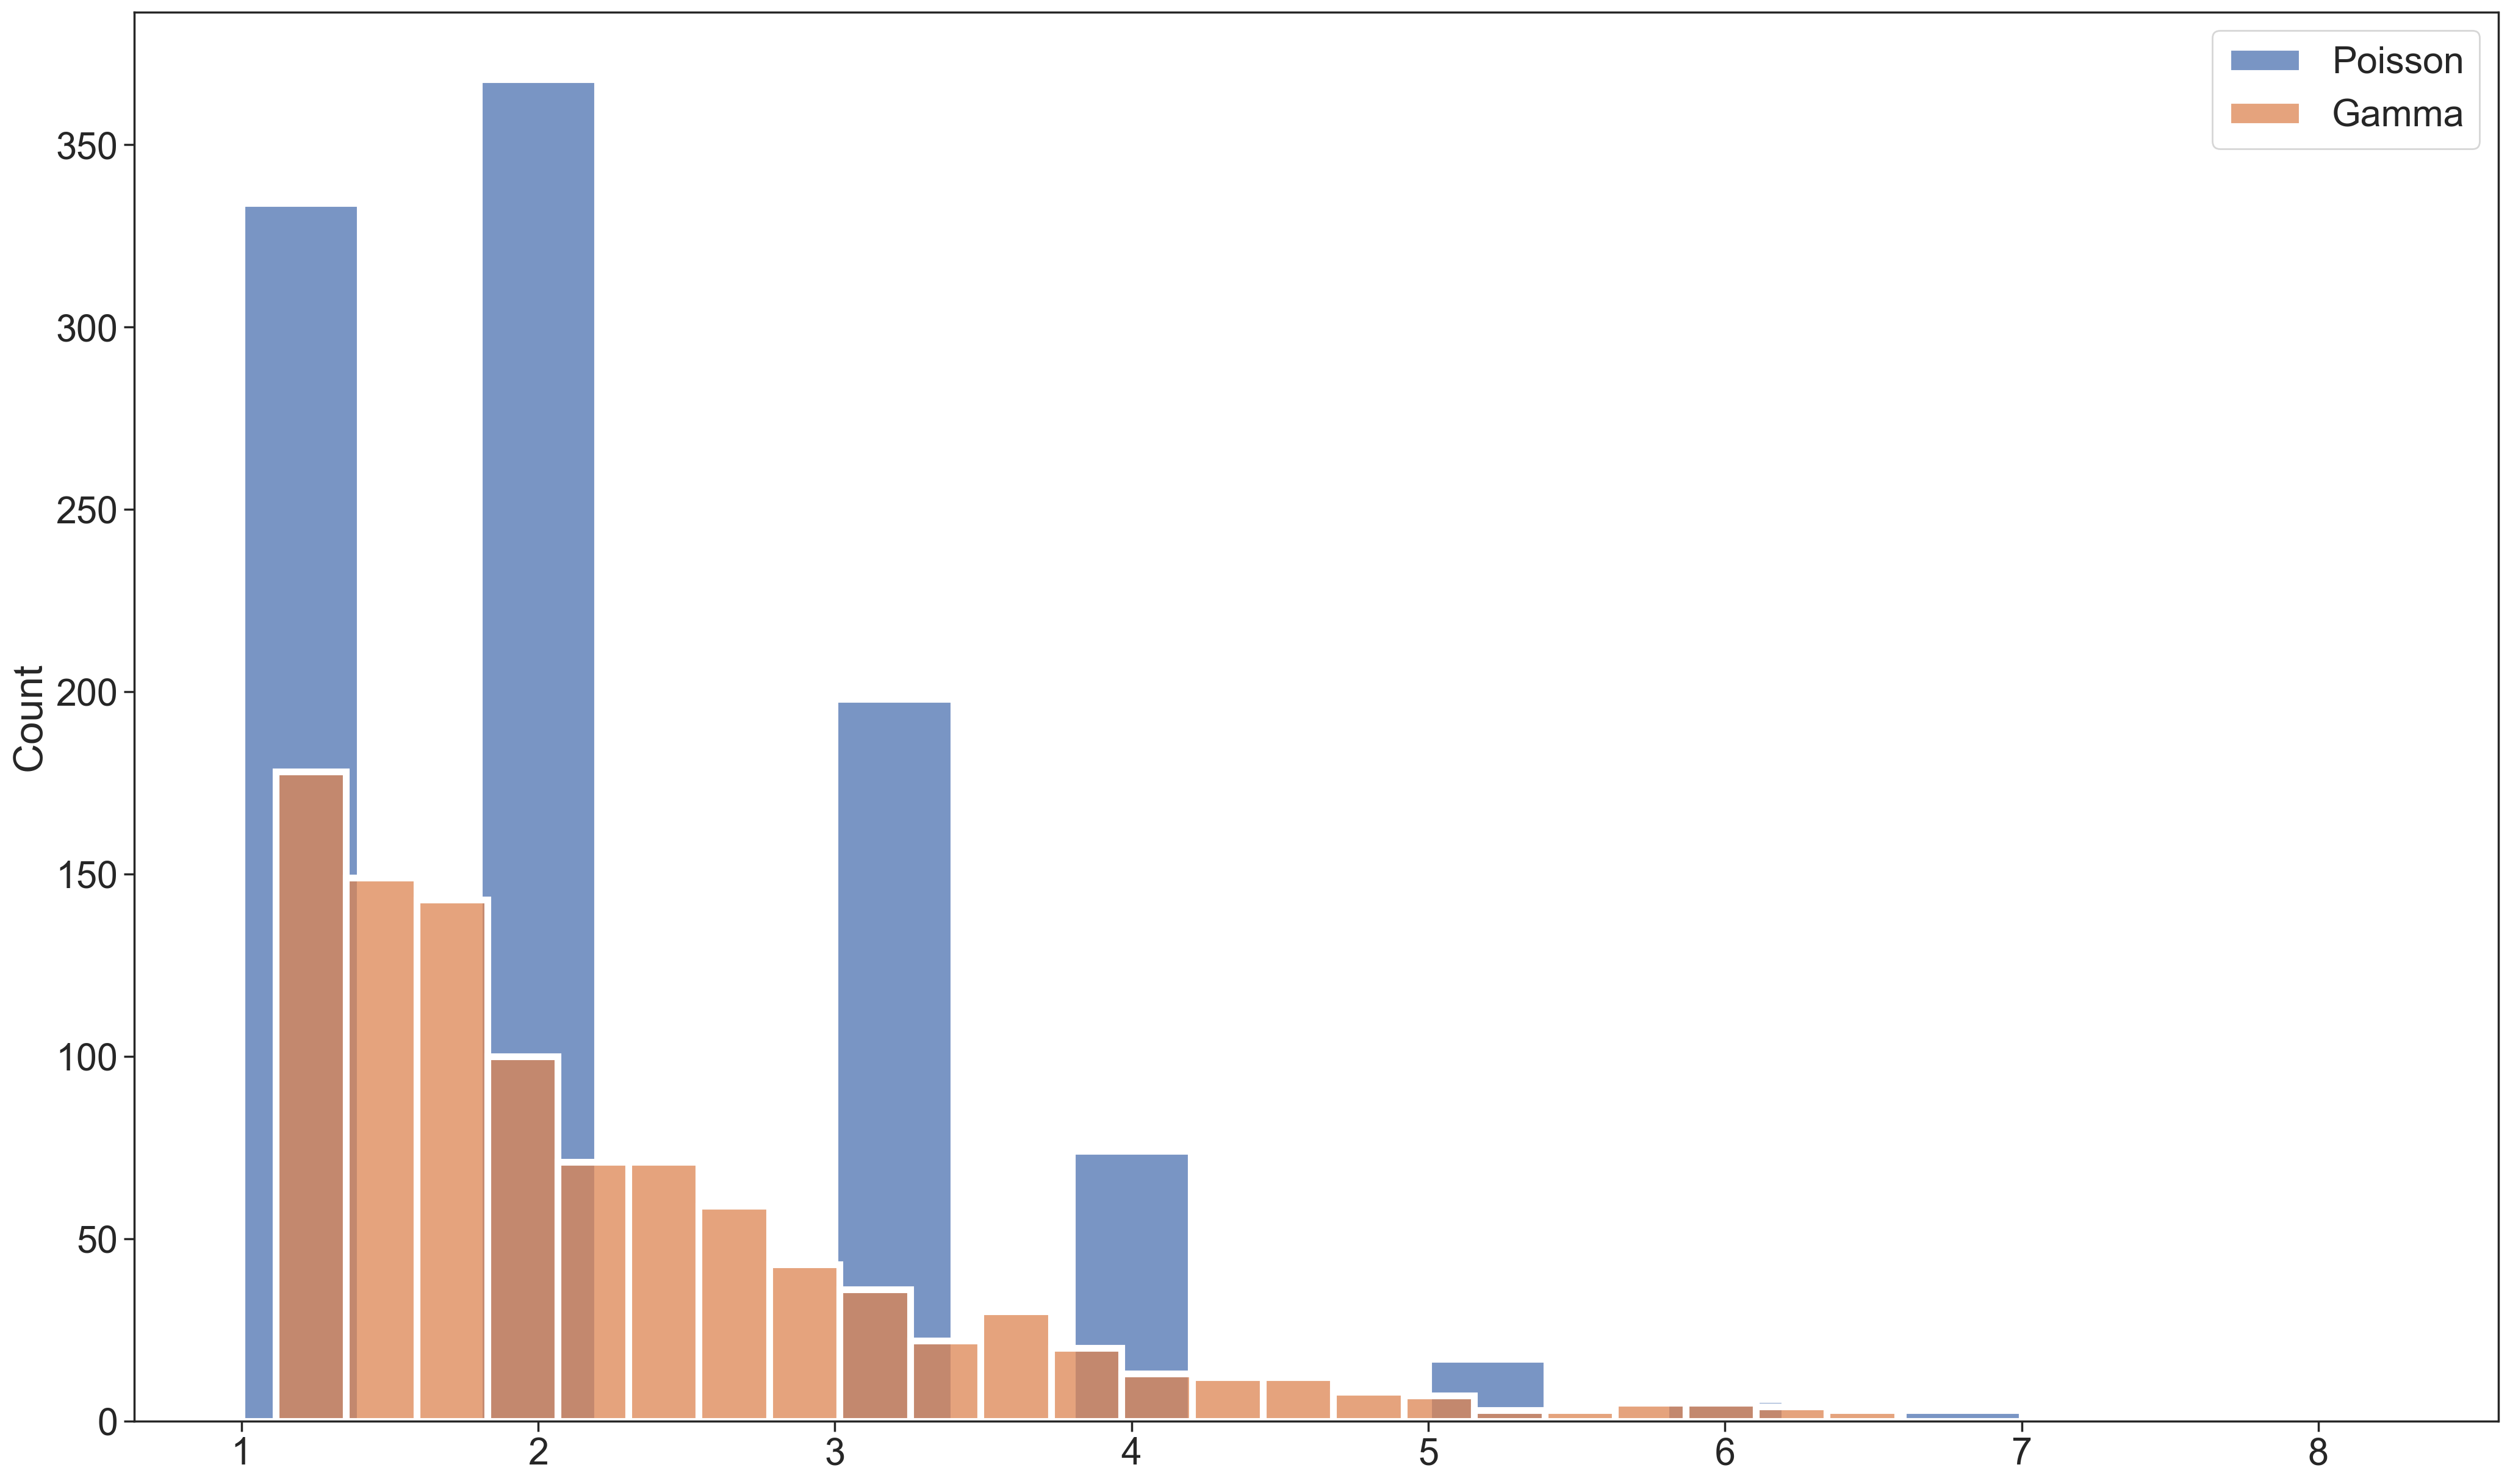

In [156]:
# ax = sns.kdeplot(x=expon.rvs(loc=2, scale=1, size=1000), linewidth=4, label="Exponential")
ax = sns.histplot(x=poisson.rvs(mu=1.115385, loc=1.115385, size=1000), linewidth=4, label="Poisson")
sns.histplot(x=gamma.rvs(a=1.115385, loc=1.115385, size=1000), linewidth=4, label="Gamma", ax=ax)
ax.legend()
plt.show()

---

In [157]:
train_df = train_df[train_df["release"] == 1].reset_index()
test_df = test_df[test_df["release"] == 1].reset_index()

In [158]:
ar = AutoReg(train_df["days_until_next_release"],
             lags=7).fit()
             # exog=train_df[["days_since_previous_release"]]).fit()

In [159]:
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               AutoReg Model Results                               
===================================================================================
Dep. Variable:     days_until_next_release   No. Observations:                  350
Model:                          AutoReg(7)   Log Likelihood                -872.861
Method:                    Conditional MLE   S.D. of innovations              3.083
Date:                     Thu, 21 Nov 2024   AIC                           1763.722
Time:                             16:26:25   BIC                           1798.261
Sample:                                  7   HQIC                          1777.480
                                       350                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          4.7878      1.085      4.414      0.000       2.662       6.914
days_until_next_release.L1    -0.2603      0.053     -4.945      0.000      -0.363      -0.157
days_until_next_release.L2    -0.0802      0.054     -1.490      0.136      -0.186       0.025
days_until_next_release.L3     0.0034      0.053      0.064      0.949      -0.101       0.108
days_until_next_release.L4     0.1204      0.053      2.282      0.023       0.017       0.224
days_until_next_release.L5     0.1838      0.053      3.453      0.001       0.079       0.288
days_until_next_release.L6     0.1828      0.054      3.390      0.001       0.077       0.288
days_until_next_release.L7     0.1780      0.052      3.444      0.001       0.077       0.279
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1388           -0.0000j            1.1388           -0.0000
AR.2            0.5631           -1.1138j            1.2481           -0.1755
AR.3            0.5631           +1.1138j            1.2481            0.1755
AR.4           -0.4292           -1.2721j            1.3426           -0.3018
AR.5           -0.4292           +1.2721j            1.3426            0.3018
AR.6           -1.2167           -0.5258j            1.3254           -0.4351
AR.7           -1.2167           +0.5258j            1.3254            0.4351
-----------------------------------------------------------------------------
"""

In [160]:
test_df["pred"] = ar.forecast(steps=len(test_df)).values
                              # exog=test_df[["days_since_previous_release"]]).values

In [161]:
wape(test_df["days_until_next_release"], test_df["pred"])

0.38559233968964796

In [162]:
test_df[["days_until_next_release", "pred"]]

,days_until_next_release,pred
0,7.0,7.623528
1,6.0,6.849188
2,6.0,6.117969
3,2.0,6.475527
4,7.0,6.623722
5,12.0,6.244094
6,7.0,7.110703
7,2.0,6.972272
8,6.0,6.749545
9,7.0,6.738276
